In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from IPython.display import SVG
import msprime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import pickle
import warnings
import tskit
import pandas as pd

In [3]:
def reverse_time(nodes, begin=0, end=None):
    
    if end is None: end = len(nodes)
    time_before = (nodes[0:begin].time).tolist()
    time_mid = ((nodes[begin:end].time - nodes.time[begin:end].max()) * (-1)).tolist()
    time_after = (nodes[end:].time).tolist()
    time = time_before  + time_mid + time_after
        
    nodes.set_columns(time=time, flags=nodes.flags)

In [4]:
def push_back_nodes(nodes, by, begin=0, end=None):
    if end is None: end = len(nodes)
    time = (nodes[:begin].time).tolist() + (nodes[begin:end].time  + by).tolist() + (nodes[end:].time).tolist()
    nodes.set_columns(time=time, flags=nodes.flags)

In [6]:
def get_dormancy_generation(N, b, m):
    # dormancy init
    weights = []
    for i in range(1, m+1): 
        weights.append(b * pow((1-b), i-1))
    weights = weights / np.sum(weights)
    dormancy_generation = np.random.choice(np.arange(0,m), size=N ,p=weights)
    return dormancy_generation

In [7]:
def infsites(mu, lookup, L=1):
    """
    :param mu (float): Mutation rate (per gamete, per generation)
    :param lookup (dict): The currently segregating positions in the population.
    
    :rtype: np.array
    
    :returns: Positions of new mutations.
    """
    nmut = np.random.poisson(mu)
    if nmut == 0:
        return np.empty([0], dtype=np.float64)
    i = 0
    rv = np.zeros(nmut)
    while i < nmut:
        pos = np.random.random_sample(1)*L
        while pos[0] in lookup:
            pos = np.random.random_sample(1)*L
        rv[i] = pos[0]
        lookup[rv[i]] = True
        i += 1
    return rv

In [8]:
def fsites(mu_s, position, lookup):
    nmut = np.random.poisson(mu_s)
    if nmut == 0:
        return np.empty([0], dtype=np.float64)
    i = 0
    rv = np.zeros(nmut)
    while i < nmut:
        pos = np.random.random_sample(1)
        while pos[0]+position in lookup:
            pos = np.random.random_sample(1)+position
        rv[i] = pos[0]+position
        lookup[rv[i]] = True
        i += 1
    return rv

In [10]:
def poisson_recombination_events(r, parent_indexes, next_offspring_id, L=1):
    
    nbreaks = np.random.poisson(r)
    recombination_events = []
    if nbreaks == 0:
        #print(0, 1, parent_indexes[0], next_offspring_id)
        recombination_events.append([0, L, parent_indexes[0], next_offspring_id])
    else:
        b = []
        i = 0
        while i < nbreaks:
            p = np.random.random_sample(1)*L
            while p[0] in b:
                p = np.random.random_sample(1)*L
            b.append(p[0])
            i += 1
        b.sort()
        b.append(L)
        
        if b[0] != 0.0:
            b.insert(0,0.0)
        else:
            parent_indexes = (parent_indexes[1], parent_indexes[0])
        
        pgams = list([*tuple(i for i in parent_indexes)]*int(len(b)/2))

        for l,r,p in zip(b[0:len(b)-1],b[1:len(b)],pgams):
            recombination_events.append([l, r, p, next_offspring_id])
            
    return recombination_events

In [12]:
def get_gamete_of_specific_position(position, recombination_evets):
    for i in range(len(recombination_evets)):
        if (position >= recombination_evets[i][0] and position <= recombination_evets[i][1]):
            
            return recombination_evets[i][2]

In [3]:
import numpy as np
samples=np.where([True, False, True])[0]
samples

array([0, 2])

In [14]:
def simplify(tables, temp_mutations, sample_generation, inplace=True):
            
    mask = [True if i in range(0,sample_generation) else False for i in tables.nodes.time]
    samples=np.where(mask)[0]
    
    if inplace:
        nodes, edges, sites, mutations = tables.nodes, tables.edges, tables.sites, tables.mutations
        for i in temp_mutations:
            sites.add_row(position=i[1].pos, ancestral_state='0')
            mutations.add_row(site=len(sites)-1, node=i[0], derived_state='1', metadata=pickle.dumps(i[1]))
        tables.sort()
        node_map = tables.simplify(samples=samples.tolist())
        return None
    else:
        new_tables = tables.copy()
        nodes, edges, sites, mutations = new_tables.nodes, new_tables.edges, new_tables.sites, new_tables.mutations
        for i in temp_mutations:
            sites.add_row(position=i[1].pos, ancestral_state='0')
            mutations.add_row(site=len(sites)-1, node=i[0], derived_state='1', metadata=pickle.dumps(i[1]))
        new_tables.sort()        
        node_map = new_tables.simplify(samples=samples.tolist())
        return new_tables

In [15]:
def get_weights(generation, domination_coefficient, selection_coefficient):

    weights = []
    
    for i in range(0, generation.shape[0], 2):
        genoptype_A = generation[i]
        genoptype_a = generation[i+1]
        if genoptype_A == 0 and genoptype_a == 0:
            weights.append(1)
        elif (genoptype_A == 1 and genoptype_a == 0) or (genoptype_A == 0 and genoptype_a == 1):
            weights.append(1 + (2 * domination_coefficient * selection_coefficient))
        elif genoptype_A == 1 and genoptype_a == 1:
            weights.append(1 + (2 * selection_coefficient))
            
    return weights

In [16]:
def merge_selection_genotypes(sg):
    
    from copy import deepcopy
    sg = deepcopy(sg)
    
    keys =  list(sg.keys())
    current_key = keys[0]
    current_genotype = sg[keys[0]]
    merged_genotypes = []
    

    for i in range(1, len(keys)):
        if int(current_key) == int(keys[i]):
            current_genotype += sg[keys[i]]
        else:
            merged_genotypes.append(current_genotype)
            current_key = int(keys[i])
            current_genotype = sg[keys[i]]

    merged_genotypes.append(current_genotype)
    merged_genotypes = np.array(merged_genotypes)
    merged_genotypes[np.array(merged_genotypes) >= 1] = 1
    
    keys = np.unique(np.int64(keys))
    merged_genotypes_dict = {}
    for i in range(len(keys)):
        merged_genotypes_dict[keys[i]] = merged_genotypes[i]
    
    return merged_genotypes_dict

In [ ]:
MutationMetaData = namedtuple('MutationMetaData',['origin','pos'])

In [84]:
def mrca_estimate(runs, N, b, m, gc, t, r):
    mrcas = []
    for i in range(runs):
        tables = dormancy(1000, N=N, b=b, m=m,  gc=gc, t=t, r=r)
        mrca = tables.tree_sequence().max_root_time
        mrcas.append(mrca)
        print(i, round(np.mean(mrcas)), np.std(mrcas), end="\r") 
    return np.mean(mrcas), np.std(mrcas)

In [200]:
def dormancy(num_generations,
             N=50,
             m=1,
             b=1,
             gc=1,
             mu=0,
             r=0,
             L=1,             
             mu_selection_rates=[0],
             selection_coefficients=[0],
             dominance_coefficients=[0.5],
             selection_positions=[0.5],
             selection_activation_generation=None,
             stop_after_mrca=False
            ):

    position_coefficient_mapping = {}
    position_dominance_mapping = {}
    for i, p in enumerate(selection_positions):
        position_coefficient_mapping[p] = selection_coefficients[i]
        position_dominance_mapping[p] = dominance_coefficients[i]
    
    tables = tskit.TableCollection(L)
    nodes, edges, sites, mutations = tables.nodes, tables.edges, tables.sites, tables.mutations
    
    selection_genotypes = {}
    next_selection_genotypes = {}
    
    # init
    gen = 0
    for i in range(m):
        for j in range(2*N):
            nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
        gen += 1
    
    reverse_time(nodes)
    simplify(tables, [], m, True)
    
    lookup = dict()
    lookup_selection = dict()
    
    temp_mutations = []    
    mutation_adding_generation = {}

    while num_generations > 0:
        next_offspring_index = len(nodes)
        first_parental_index = next_offspring_index - (2*N) - (nodes.flags != 1).sum()
        non_sample_nodes = (nodes.flags != 1).sum()
        
        for c in range(gc):
            dormancy_generation = get_dormancy_generation(N=2*N, b=b, m=m)
            
            if selection_activation_generation and gen > selection_activation_generation and len(list(selection_genotypes.keys())) != 0:
                merged_selection_genotypes = merge_selection_genotypes(selection_genotypes)
                #for k,v in zip(merged_selection_genotypes.keys(), merged_selection_genotypes.values()):
                #    print(k, str(list(v[0])))
                
                parents = []   
                for d in dormancy_generation:
                    total_weights = []
                    for mi in sorted(merged_selection_genotypes.keys()):
                        weights = get_weights(merged_selection_genotypes[mi][m-1-d], 
                                              position_dominance_mapping[round(mi)], position_coefficient_mapping[round(mi)])
                        total_weights.append(weights)
                    muliplied_weights = []
                    for j in range(len(total_weights[0])):
                        weight = 1
                        for i in range(len(total_weights)):
                            weight *= total_weights[i][j]
                        muliplied_weights.append(weight)
                    muliplied_weights = np.array(muliplied_weights) / np.sum(muliplied_weights)
                    parent = np.random.choice(np.arange(0, N), p=muliplied_weights)                    
                    parents.append(parent)
            else:
                parents = np.random.randint(0, N, 2*N)
                                        
            i_genotype = 0
            for parent1, parent2 in zip(parents[::2], parents[1::2]):

                dormancy_updated_first_parental_index_1 = first_parental_index - (2*N*dormancy_generation[parent1]) 
                dormancy_updated_first_parental_index_2 = first_parental_index - (2*N*dormancy_generation[parent2])

                if c > 0 and (2*N*dormancy_generation[parent1]) >= c * 2*N :
                    dormancy_updated_first_parental_index_1 -= non_sample_nodes 

                if c > 0 and (2*N*dormancy_generation[parent2]) >= c * 2*N :  
                    dormancy_updated_first_parental_index_2 -= non_sample_nodes

                p1g1 = dormancy_updated_first_parental_index_1 + 2*parent1
                p1g2 = p1g1+1
                p2g1 = dormancy_updated_first_parental_index_2 + 2*parent2
                p2g2 = p2g1+1
                
                mendel = np.random.random_sample(2)
                if mendel[0] < 0.5: p1g1, p1g2 = p1g2, p1g1
                if mendel[1] < 0.5: p2g1, p2g2 = p2g2, p2g1

                nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
                nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
                
                # parent 1
                # sample recombination event
                recombination_events = poisson_recombination_events(r, (p1g1,p1g2), next_offspring_index, L)
                                
                # selection mutation tracking
                if selection_activation_generation and gen > selection_activation_generation:
                    for mi in sorted(lookup_selection.keys()):
                        if not mutation_adding_generation[mi]:
                            genotype = selection_genotypes[mi][m-1-dormancy_generation[parent1]][get_gamete_of_specific_position(mi, recombination_events) - dormancy_updated_first_parental_index_1]
                            next_selection_genotypes[mi][0][i_genotype] = genotype
                    for i in range(len(mu_selection_rates)):
                        mpos_selection = fsites(mu_selection_rates[i], selection_positions[i], lookup_selection)
                        for mi in mpos_selection:   
                            mutation_adding_generation[mi] = True
                            temp_mutations.append((next_offspring_index, MutationMetaData(gen, mi)))
                            selection_genotypes[mi] = np.zeros(shape=(m, 2*N), dtype=np.int8)
                            next_selection_genotypes[mi] = np.zeros(shape=(1, 2*N), dtype=np.int8)
                            next_selection_genotypes[mi][0][i_genotype] = 1
                            
                # adding recombinations
                for re in recombination_events:
                    edges.add_row(left=re[0], right=re[1], parent=re[2],child=re[3])
                # adding regular mutations
                mpos = infsites(mu,lookup, L)
                for mi in mpos:
                    temp_mutations.append((next_offspring_index, MutationMetaData(gen,mi)))
                i_genotype += 1
                next_offspring_index +=1
                
                # parent 2
                recombination_events = poisson_recombination_events(r, (p2g1,p2g2), next_offspring_index, L)
                # selection mutation tracking
                if selection_activation_generation and gen > selection_activation_generation:
                    for mi in sorted(lookup_selection.keys()):
                        if not mutation_adding_generation[mi]:
                            genotype = selection_genotypes[mi][m-1-dormancy_generation[parent2]][get_gamete_of_specific_position(mi, recombination_events) - dormancy_updated_first_parental_index_2]
                            next_selection_genotypes[mi][0][i_genotype] = genotype
                    for i in range(len(mu_selection_rates)):
                        mpos_selection = fsites(mu_selection_rates[i], selection_positions[i], lookup_selection)
                        for mi in mpos_selection:   
                            #print(f"added {mi}")
                            mutation_adding_generation[mi] = True
                            temp_mutations.append((next_offspring_index, MutationMetaData(gen, mi)))
                            selection_genotypes[mi] = np.zeros(shape=(m, 2*N), dtype=np.int8)
                            #selection_genotypes[mi][m-1][i_genotype] = 1
                            next_selection_genotypes[mi] = np.zeros(shape=(1, 2*N), dtype=np.int8)
                            next_selection_genotypes[mi][0][i_genotype] = 1
                # adding recombinations
                for re in recombination_events:
                    edges.add_row(left=re[0], right=re[1], parent=re[2],child=re[3])
                # adding regular mutations
                mpos = infsites(mu,lookup, L)
                for mi in mpos:
                    temp_mutations.append((next_offspring_index, MutationMetaData(gen,mi)))
                i_genotype += 1
                next_offspring_index +=1

            first_parental_index = len(nodes) - 2*N 
            
            if m > 1:
                for mi in sorted(lookup_selection.keys()):
                    for i in range(1, selection_genotypes[mi].shape[0]): 
                        selection_genotypes[mi][i-1] = selection_genotypes[mi][i]  
                
            lost_mutations = []
            fixed_mutations = []
            for mi in sorted(lookup_selection.keys()):
                if next_selection_genotypes[mi][0].sum() == 0:
                    lost_mutations.append(mi)
                elif next_selection_genotypes[mi][0].sum() == 2*N:
                    fixed_mutations.append(mi)
                else:
                    selection_genotypes[mi][m-1] = next_selection_genotypes[mi][0]
                    next_selection_genotypes[mi] = np.zeros(shape=(1, 2*N), dtype=np.int8)
                    
            for mi in lost_mutations:
                del lookup_selection[mi]
                del selection_genotypes[mi]
                del next_selection_genotypes[mi]
                
            for mi in fixed_mutations:
                push_back_nodes(tables.nodes, by=c+1, begin=0, end=len(tables.nodes)-2*N*(c+1))
                reverse_time(tables.nodes, begin=len(tables.nodes)-2*N*(c+1), end=len(tables.nodes))   
                simplify(tables, temp_mutations, 1, True) 
                return tables
                
                del lookup_selection[mi]
                del selection_genotypes[mi]
                del next_selection_genotypes[mi]
            
            
            for i in mutation_adding_generation.keys():
                mutation_adding_generation[i] = False
                                
            gen += 1
            # only for selection debugging
            #tables_selection = tables.copy()
            #push_back_nodes(tables_selection.nodes, by=c+1, begin=0, end=len(tables_selection.nodes)-2*N*(c+1))
            #reverse_time(tables_selection.nodes, begin=len(tables_selection.nodes)-2*N*(c+1), end=len(tables_selection.nodes))   
            #simplify(tables_selection, temp_mutations, 1, True) 
            #ts = tables_selection.tree_sequence()
            #genotype_matrix = ts.genotype_matrix()
            #if len(genotype_matrix) != 0:
            #    positions = [v.position for v in tables_selection.tree_sequence().variants()]
            #    print(f"position:  {positions}")
            #    print(f"genotype_matrix [0] {genotype_matrix}")
            #    for mi in sorted(lookup_selection.keys()):
            #        #print(f"genotype_matrix [1] {selection_genotypes[mi][m-1]} {mi}")
            #        print(f"genotype_matrix [1] {selection_genotypes[mi]} {mi}")
            #    print()
            
        push_back_nodes(nodes, by=gc, begin=0, end=len(nodes)-2*N*gc)
        reverse_time(nodes, begin=len(nodes)-2*N*gc, end=len(nodes))  
        
        # only for selection debugging
        #tables_selection = tables.copy()
        #simplify(tables_selection, temp_mutations, 1, True) 
        #ts = tables_selection.tree_sequence()
        #genotype_matrix = ts.genotype_matrix()
        #if len(genotype_matrix) != 0:
            #positions = [v.position for v in tables_selection.tree_sequence().variants()]
            #print(f"position:  {positions}")
            #print(f"genotype_matrix [0] {genotype_matrix}")
            
            #for mi in sorted(lookup_selection.keys()):
            #    print(f"genotype_matrix [1] {selection_genotypes[mi][m-1]} {mi}")
                
            #print()
        
        
        simplify(tables, temp_mutations, m, True) 
        
        # check mrca
        if stop_after_mrca:
            tables_copy = simplify(tables, temp_mutations, 1, False) 
            if tables_copy.tree_sequence().first().num_roots == 1:
                return tables_copy
        
        
        temp_mutations.clear()        
        num_generations -= 1
        
    simplify(tables, temp_mutations, 1, True) 
    return tables

## wd 

In [85]:
# 400
mrca_estimate(runs=10, N=100, t=0, r=0, b=0.5, m=50, gc=25, stop_after_mrca=True)

(468.9, 150.43101408951546)

In [2043]:
# 625
mrca_estimate(runs=10, N=100,t=0, r=0, b=0.4, m=50, gc=25, stop_after_mrca=True)

(720.9, 183.06416907740302)

In [2044]:
# 1111
mrca_estimate(runs=10, N=100, b=0.3,t=0, r=0, m=50, gc=25, stop_after_mrca=True)

(1086.5, 291.59946844944693)

In [2045]:
# 2500
mrca_estimate(runs=10, N=100, b=0.2,t=0, r=0, m=50, gc=25, stop_after_mrca=True)

(2268.5, 727.8093500361203)

In [2046]:
# 10000
mrca_estimate(runs=10, N=100, b=0.1, m=50,t=0, r=0, gc=25, stop_after_mrca=True)

(9417.4, 3767.1766669483395)

In [121]:
def normalize_diversity(data): return data / data[0:5].mean()

In [206]:
def wf_parameters1():
    return dormancy(num_generations=2000,
                    m=1, b=1, N=100, r=0.5, mu=0.5,
                    mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[0.5],
                    gc=4, L=1000, selection_activation_generation=500, stop_after_mrca=False)

def wd_parameters1():
    return dormancy(num_generations=2000,
                    m=20, b=0.3, N=100, r=0.5, mu=0,
                    mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[0.5],
                    gc=4, L=1000, selection_activation_generation=500, stop_after_mrca=False)

In [208]:
tables_wf_param1 = []
for i in range(10): 
    print(i, end="\r")
    tables_wf_param1.append(wf_parameters1())

In [176]:
tables_wd_param1 = []
for i in range(20): 
    print(i, end="\r")
    tables_wd_param1.append(wd_parameters1())

KeyboardInterrupt: 

In [210]:
diversities_wf = []
for table in tables_wf_param1:
    ts = table.tree_sequence()
    diversity = ts.diversity(windows=np.linspace(0, 1000),mode="site")
    diversities_wf.append(diversity)
diversities_wf = np.mean(diversities_wf, axis=0)
#diversities_wf = normalize_diversity(diversities_wf)

diversities_wf = pd.DataFrame(diversities_wf)
diversities_wf["model"] = "wf"
diversities_wf.columns = ["diversity", "model"]

In [181]:
diversities_wd = []
for table in tables_wd_param1:
    ts = table.tree_sequence()
    diversity = ts.diversity(windows=np.linspace(0, 1000),mode="branch")
    diversities_wd.append(diversity)

diversities_wd = np.mean(diversities_wd, axis=0)
#diversities_wd = normalize_diversity(diversities_wd)

diversities_wd = pd.DataFrame(diversities_wd)
diversities_wd["model"] = "wd"

/home/anon/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anon/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: DataFrame constructor not properly called!

In [149]:
diversities = pd.concat([diversities_wf, diversities_wd])
diversities.columns = ["diversity", "model"]

<AxesSubplot:ylabel='diversity'>

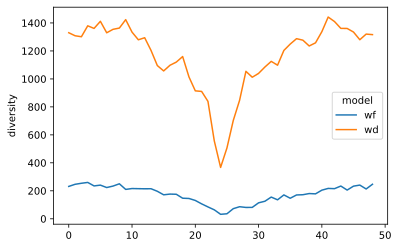

In [150]:
sns.lineplot(data=diversities,x=diversities.index, y="diversity", hue="model")

In [205]:
def wf_parameters2_overdominance():
    return dormancy(num_generations=2000,
                    m=1, b=1, N=100, r=0.5, mu=0,
                    mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[1.1],
                    gc=4, L=1000, selection_activation_generation=500, stop_after_mrca=False)

In [187]:
tables_wf_param2 = []
for i in range(20): 
    print(i, end="\r")
    tables_wf_param2.append(wf_parameters2_overdominance())

In [188]:
diversities_wf_param2 = []
for table in tables_wf_param2:
    ts = table.tree_sequence()
    diversity = ts.diversity(windows=np.linspace(0, 1000),mode="branch")
    diversities_wf_param2.append(diversity)
diversities_wf_param2 = np.mean(diversities_wf_param2, axis=0)
#diversities_wf = normalize_diversity(diversities_wf_param2)

diversities_wf_param2 = pd.DataFrame(diversities_wf_param2)
diversities_wf_param2["model"] = "wf"
diversities_wf_param2.columns = ["diversity", "model"]

In [ ]:
tables_wf_param1

<AxesSubplot:ylabel='diversity'>

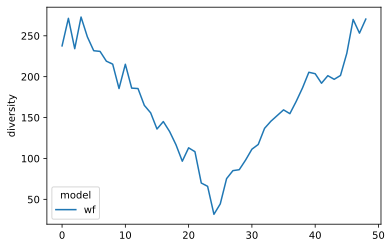

In [186]:
sns.lineplot(data=diversities_wf, x=diversities_wf.index, y="diversity", hue="model")

<AxesSubplot:ylabel='diversity'>

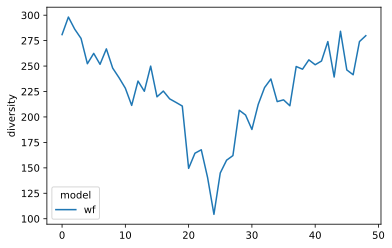

In [189]:
sns.lineplot(data=diversities_wf_param2, x=diversities_wf_param2.index, y="diversity", hue="model")

In [193]:
def wf_parameters3_noseedmut():
    return dormancy(num_generations=2000,
                    m=1, b=1, N=100, r=0.5, mu=0.5,
                    mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[1.1],
                    gc=4, L=1000, selection_activation_generation=500, stop_after_mrca=False)

In [211]:
def wd_parameters4_noseedmut():
    return dormancy(num_generations=2000,
                    m=50, b=0.5, N=100, r=0.5, mu=0.5,
                    mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[1.1],
                    gc=4, L=1000, selection_activation_generation=500, stop_after_mrca=False)

In [201]:
tables_wf_param3 = []
for i in range(10): 
    print(i, end="\r")
    tables_wf_param3.append(wf_parameters3_noseedmut())

In [212]:
tables_wd_param4 = []
for i in range(10): 
    print(i, end="\r")
    tables_wd_param4.append(wd_parameters4_noseedmut())

In [203]:
diversities_wf_param3 = []
for table in tables_wf_param3:
    ts = table.tree_sequence()
    diversity = ts.diversity(windows=np.linspace(0, 1000),mode="site")
    diversities_wf_param3.append(diversity)
diversities_wf_param3 = np.mean(diversities_wf_param3, axis=0)
#diversities_wf = normalize_diversity(diversities_wf_param2)

diversities_wf_param3 = pd.DataFrame(diversities_wf_param3)
diversities_wf_param3["model"] = "wf"
diversities_wf_param3.columns = ["diversity", "model"]

In [213]:
diversities_wd_param4= []
for table in tables_wd_param4:
    ts = table.tree_sequence()
    diversity = ts.diversity(windows=np.linspace(0, 1000),mode="site")
    diversities_wd_param4.append(diversity)
diversities_wd_param4 = np.mean(diversities_wd_param4, axis=0)
#diversities_wf = normalize_diversity(diversities_wf_param2)

diversities_wd_param4 = pd.DataFrame(diversities_wd_param4)
diversities_wd_param4["model"] = "wf"
diversities_wd_param4.columns = ["diversity", "model"]

<AxesSubplot:ylabel='diversity'>

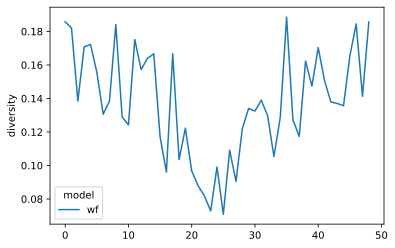

In [204]:
sns.lineplot(data=diversities_wf_param3, x=diversities_wf_param3.index, y="diversity", hue="model")

<AxesSubplot:ylabel='diversity'>

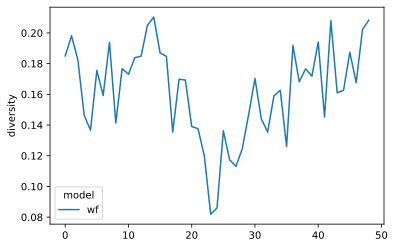

In [214]:
sns.lineplot(data=diversities_wd_param4, x=diversities_wf.index, y="diversity", hue="model")

<AxesSubplot:>

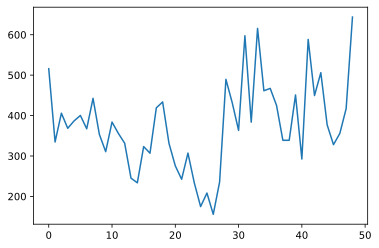

In [55]:
ts = table.tree_sequence()
diversity = ts.diversity(windows=np.linspace(0, 1000), mode="branch")
sns.lineplot(data=diversity)

In [57]:
table = dormancy(num_generations=2000,
                 m=20, b=0.5, N=100, r=0.5, mu=0,
                 mu_selection_rates=[0.00005], selection_positions=[500], selection_coefficients=[5], dominance_coefficients=[1.2],
                 gc=4, L=1000, selection_activation_generation=500)

<AxesSubplot:>

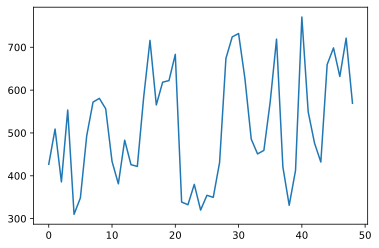

In [58]:
ts = table.tree_sequence()
diversity = ts.diversity(windows=np.linspace(0, 1000), mode="branch")
sns.lineplot(data=diversity)

<AxesSubplot:>

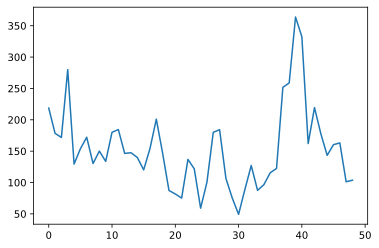

In [26]:
ts = tskit.load("test.trees")
diversity = ts.diversity(windows=np.linspace(0, 5000),mode="branch")
sns.lineplot(data=diversity)

<AxesSubplot:>

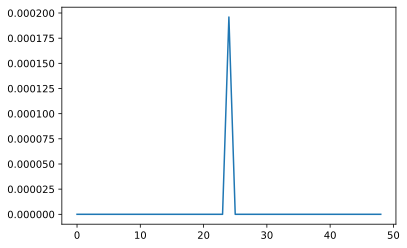

In [9]:
ts = tskit.load("test.trees")
diversity = ts.diversity(windows=np.linspace(0, 5000),mode="site")
sns.lineplot(data=diversity)

In [59]:
diversity = ts.diversity(windows=np.linspace(0, 1000),mode="branch")
sns.lineplot(data=diversity)

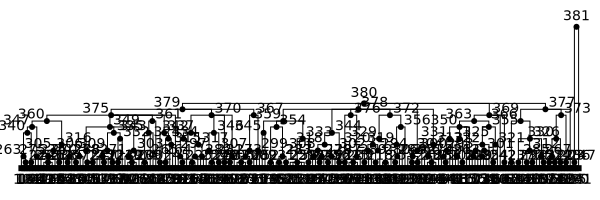

In [61]:
SVG(ts.first().draw(width=600))

In [63]:
#SVG(ts.draw_svg())